<a href="https://colab.research.google.com/github/gabrielbchacon/my_data_portfolio/blob/main/Clustering_Project_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup
- Installation and import of libraries
- Data import


In [15]:
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import math

In [17]:
# Path to the zip file
zip_file_path = "/content/telco-customer-churn.zip"

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to a specified directory
    zip_ref.extractall("/content/")

In [18]:
# Load the Data
data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')



## Step 1: Understanding the Data

- Explore the Data: Let's take a look at the data to understand its structure, variable types, distribution, etc.
- Data Cleaning (if necessary): Identify and address any missing values, duplicate or inconsistent data, if present.

The dataset includes information on:

- Customers who left last month – the column is called Churn
- Services each customer has subscribed to – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming of TV and movies
- Customer account information – how long they have been customers, contract type, payment method, paperless billing, monthly charges, and total charges
- Demographic information about customers – gender, age group, and whether they have partners and dependents


In [19]:
# View the First Rows of Data
print("First rows of data:")
print(data.head())

# Check the Number of Rows and Columns
print("\nNumber of rows and columns:")
print(data.shape)

# Check the Column Data Types
print("\nColumn data types:")
print(data.dtypes)

# Check for Missing Values
print("\nMissing values per column:")
print(data.isnull().sum())

# Check for Duplicates
print("\nNumber of duplicates:")
print(data.duplicated().sum())


First rows of data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies 

In [20]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [21]:
columns_categ = ['MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract',
       'PaymentMethod']
columns_num = ['tenure', 'MonthlyCharges', 'TotalCharges']

columns_bool = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling', 'Churn']

In [22]:
# Convert 'Yes'/'No' Columns to Boolean Values
data['gender'] = data['gender'].replace({'Female': 1, 'Male': 0})
data['Partner'] = data['Partner'].replace({'Yes': 1, 'No': 0})
data['Dependents'] = data['Dependents'].replace({'Yes': 1, 'No': 0})
data['PhoneService'] = data['PhoneService'].replace({'Yes': 1, 'No': 0})
data['PaperlessBilling'] = data['PaperlessBilling'].replace({'Yes': 1, 'No': 0})
data['Churn'] = data['Churn'].replace({'Yes': 1, 'No': 0})

data['gender'] = data['gender'].astype(bool)
data['SeniorCitizen'] = data['SeniorCitizen'].astype(bool)
data['Partner'] = data['Partner'].astype(bool)
data['Dependents'] = data['Dependents'].astype(bool)
data['PhoneService'] = data['PhoneService'].astype(bool)
data['PaperlessBilling'] = data['PaperlessBilling'].astype(bool)
data['Churn'] = data['Churn'].astype(bool)

# Formatting Numeric Columns
data['TotalCharges'] = data.apply(lambda row: row['MonthlyCharges'] * row['tenure'] if row['TotalCharges'] == ' ' else row['TotalCharges'], axis=1)
data['TotalCharges'] = data['TotalCharges'].astype(float)



In [23]:
# Check Statistical Summary of Numeric Variables
print("\nStatistical summary of numeric variables:")
print(data[columns_num].describe())



Statistical summary of numeric variables:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


In [24]:
data['Churn'].value_counts()

Churn
False    5174
True     1869
Name: count, dtype: int64

## Step 2: Exploratory Data Analysis (EDA)

- Univariate Analysis: Examine the distributions of each individual variable.
- Bivariate Analysis: Investigate the relationships between pairs of variables.


### Univariate Analysis


In [25]:
# Set the Style for Plots
sns.set(style="whitegrid")


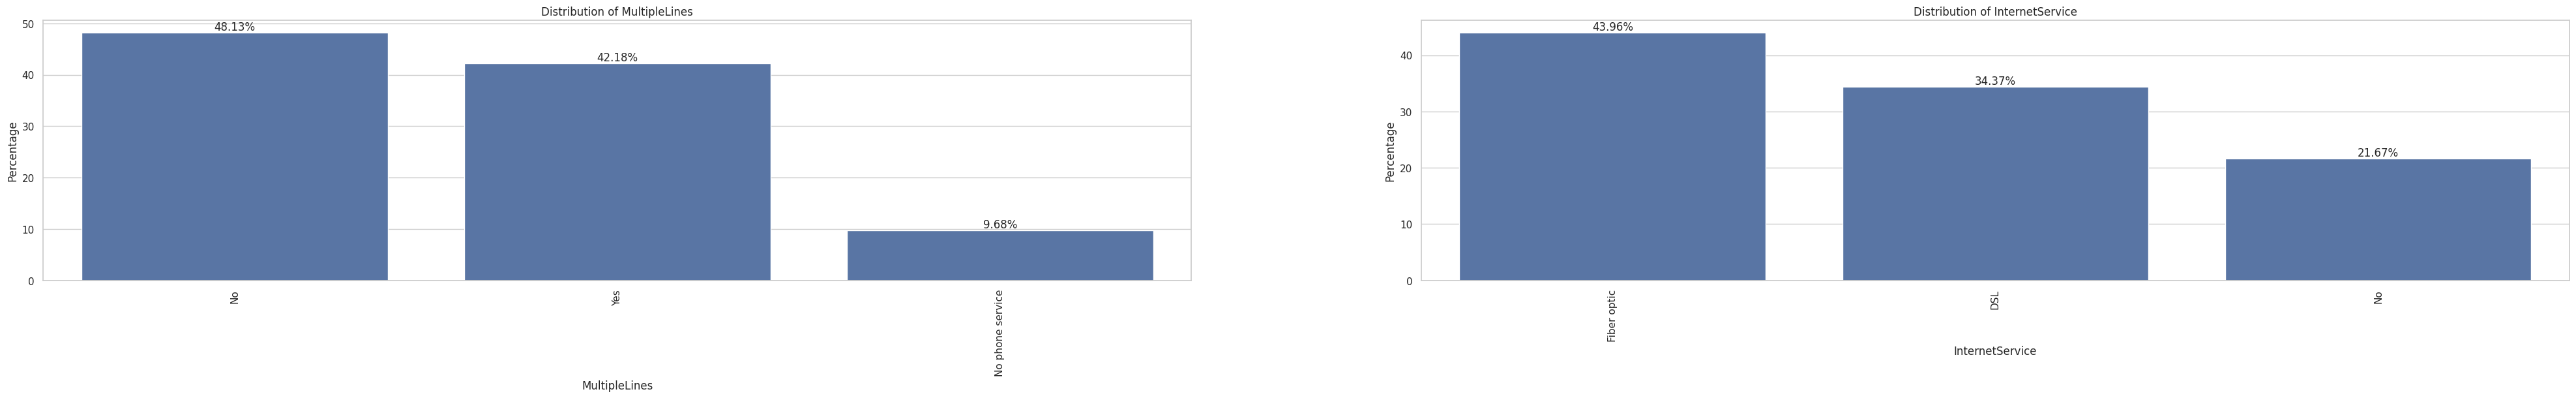

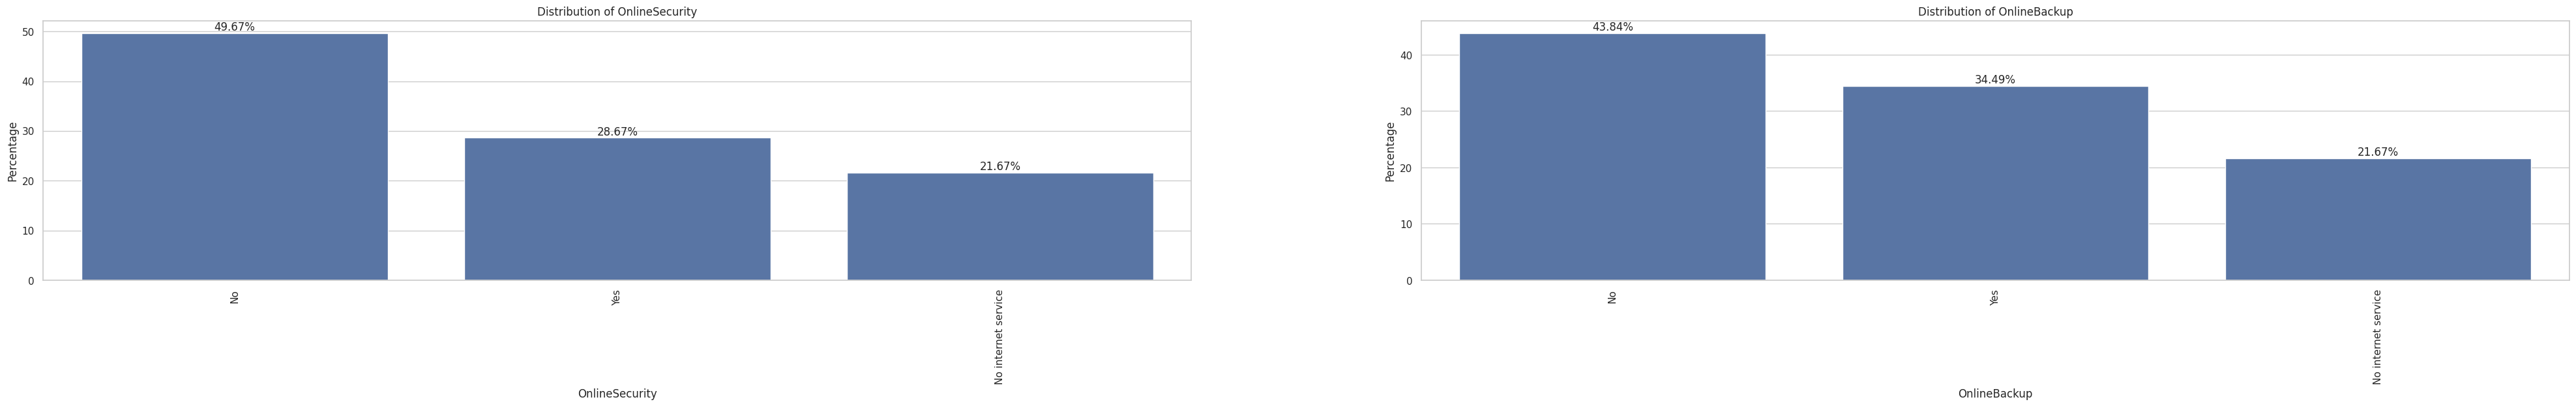

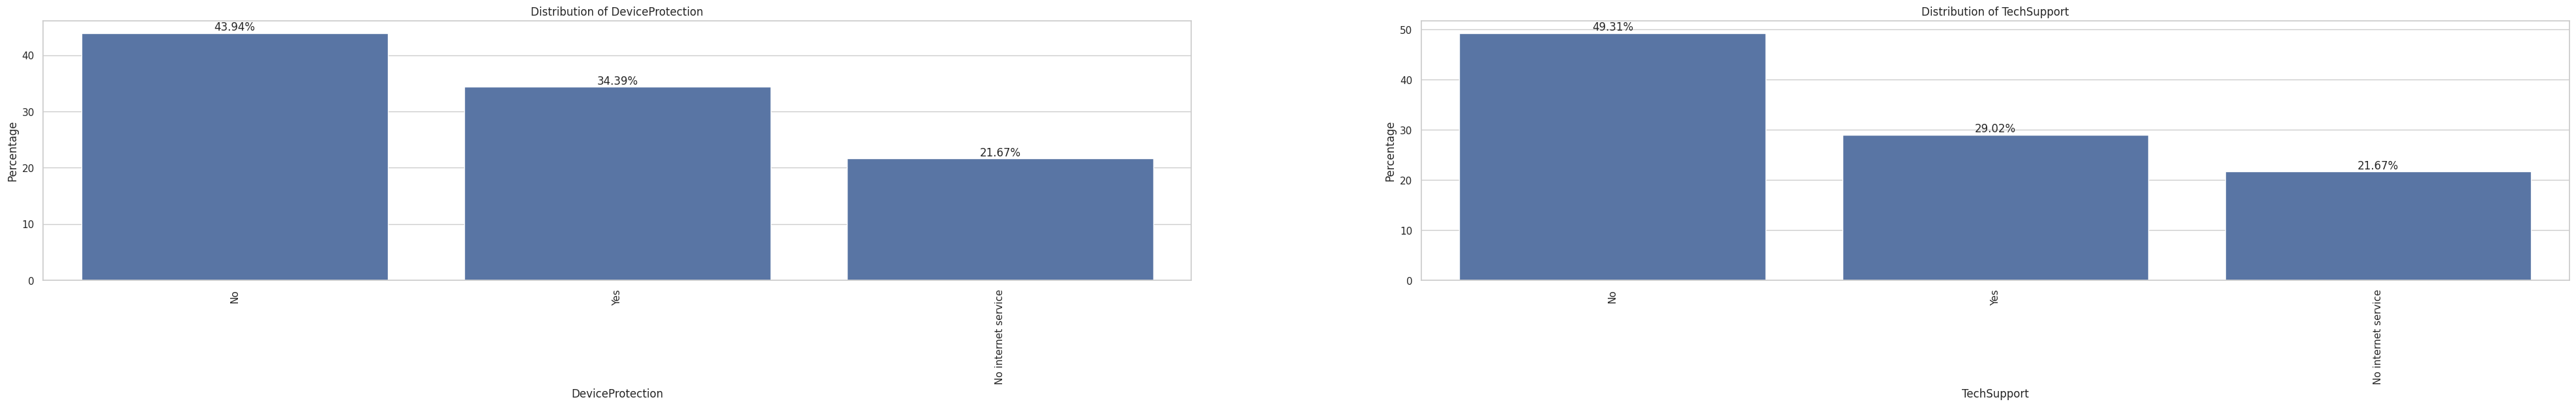

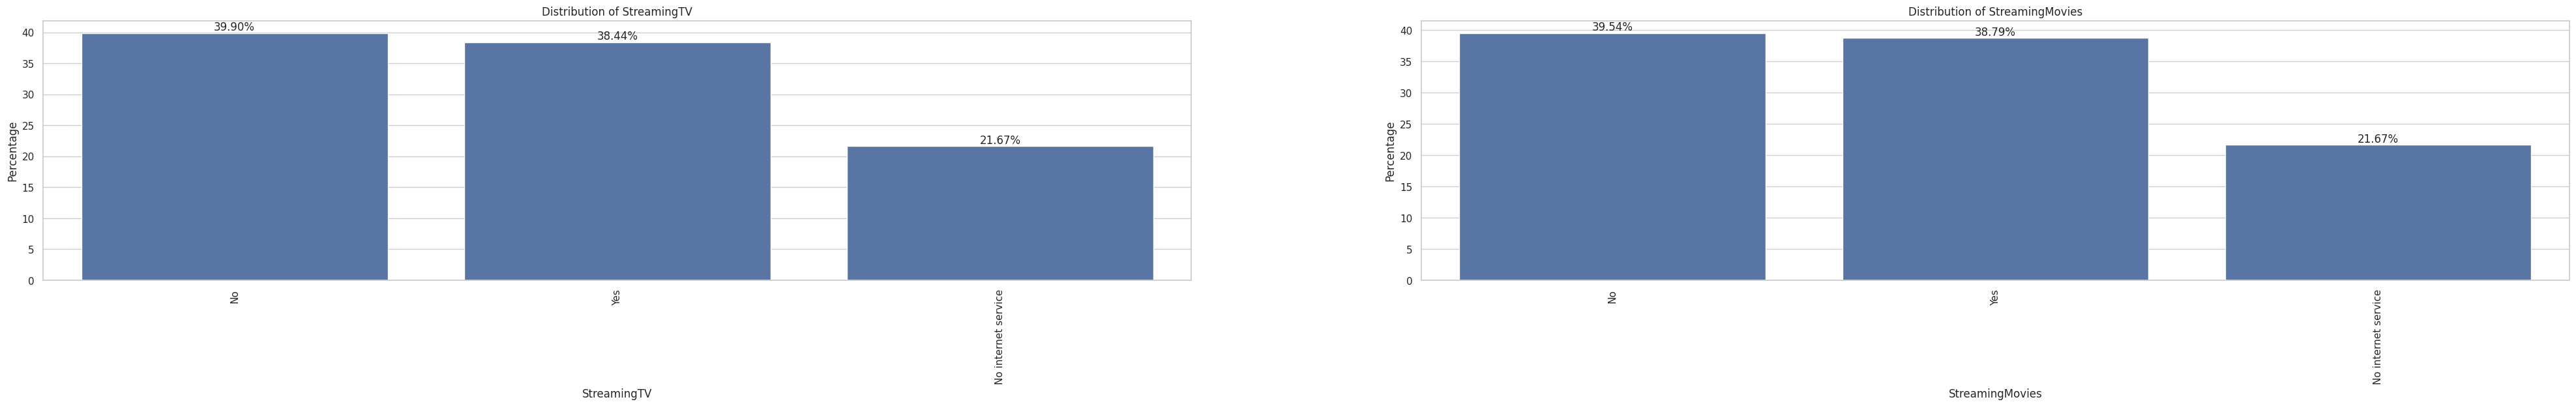

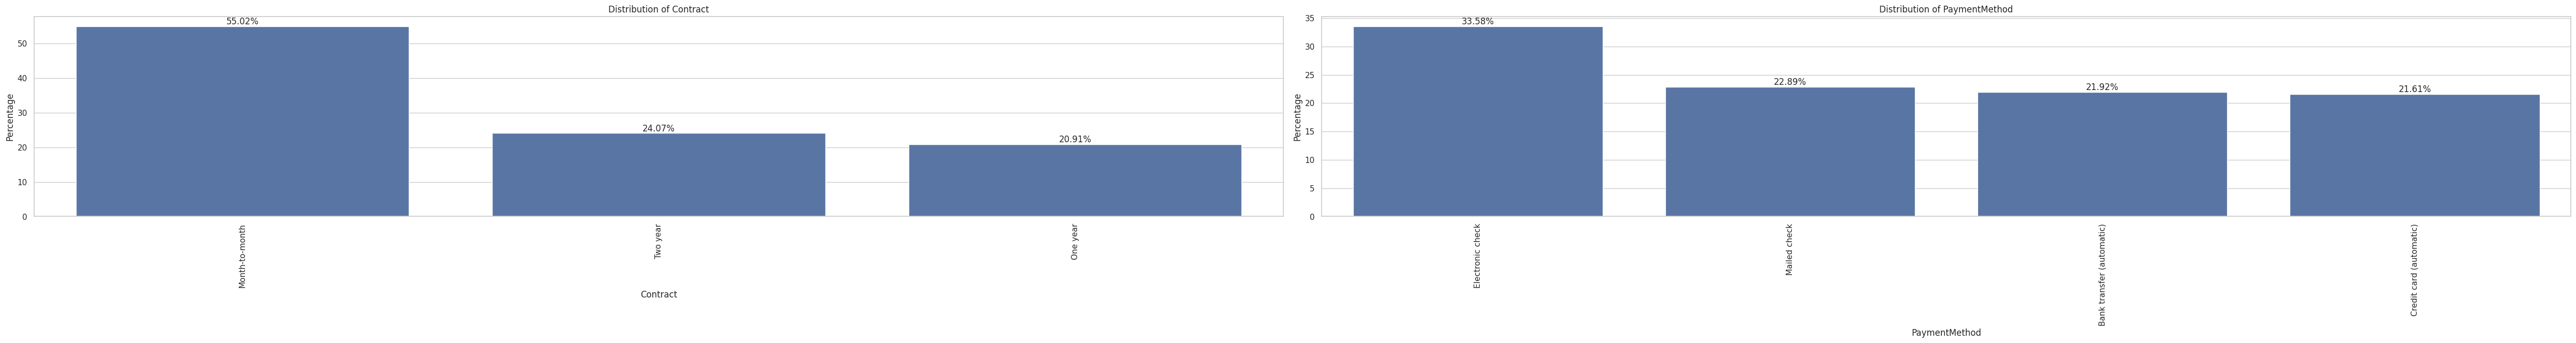

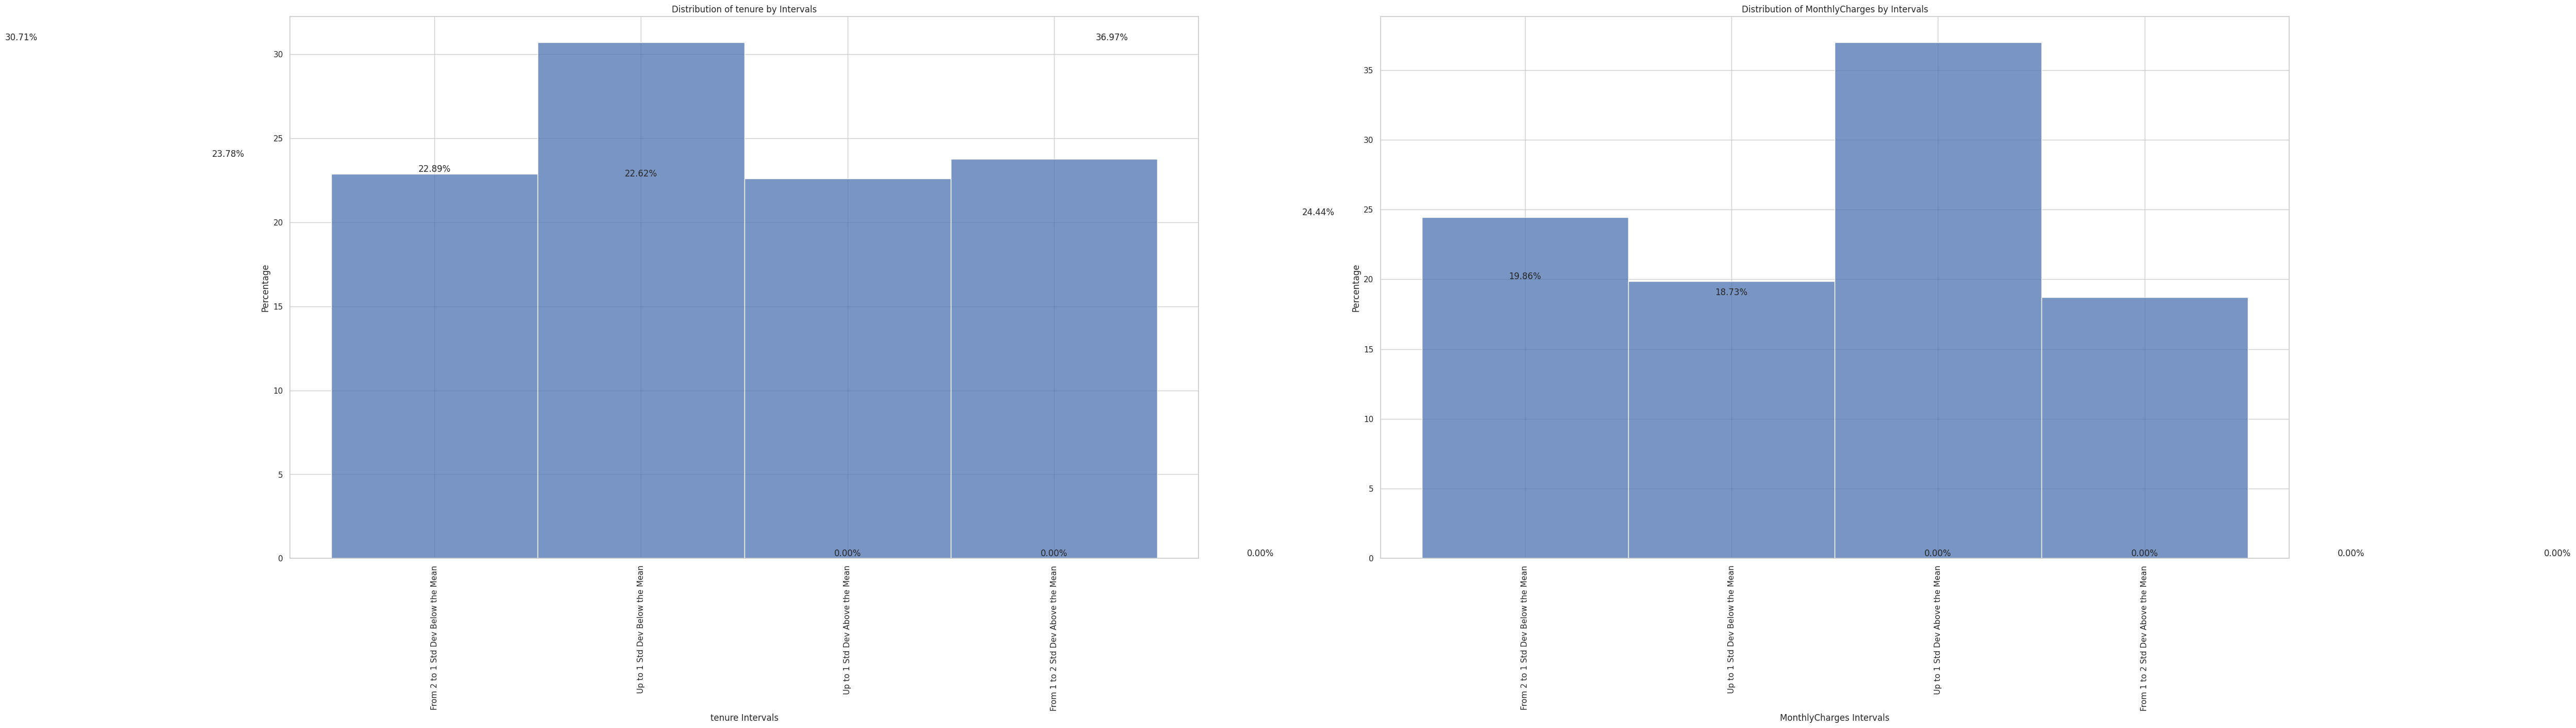

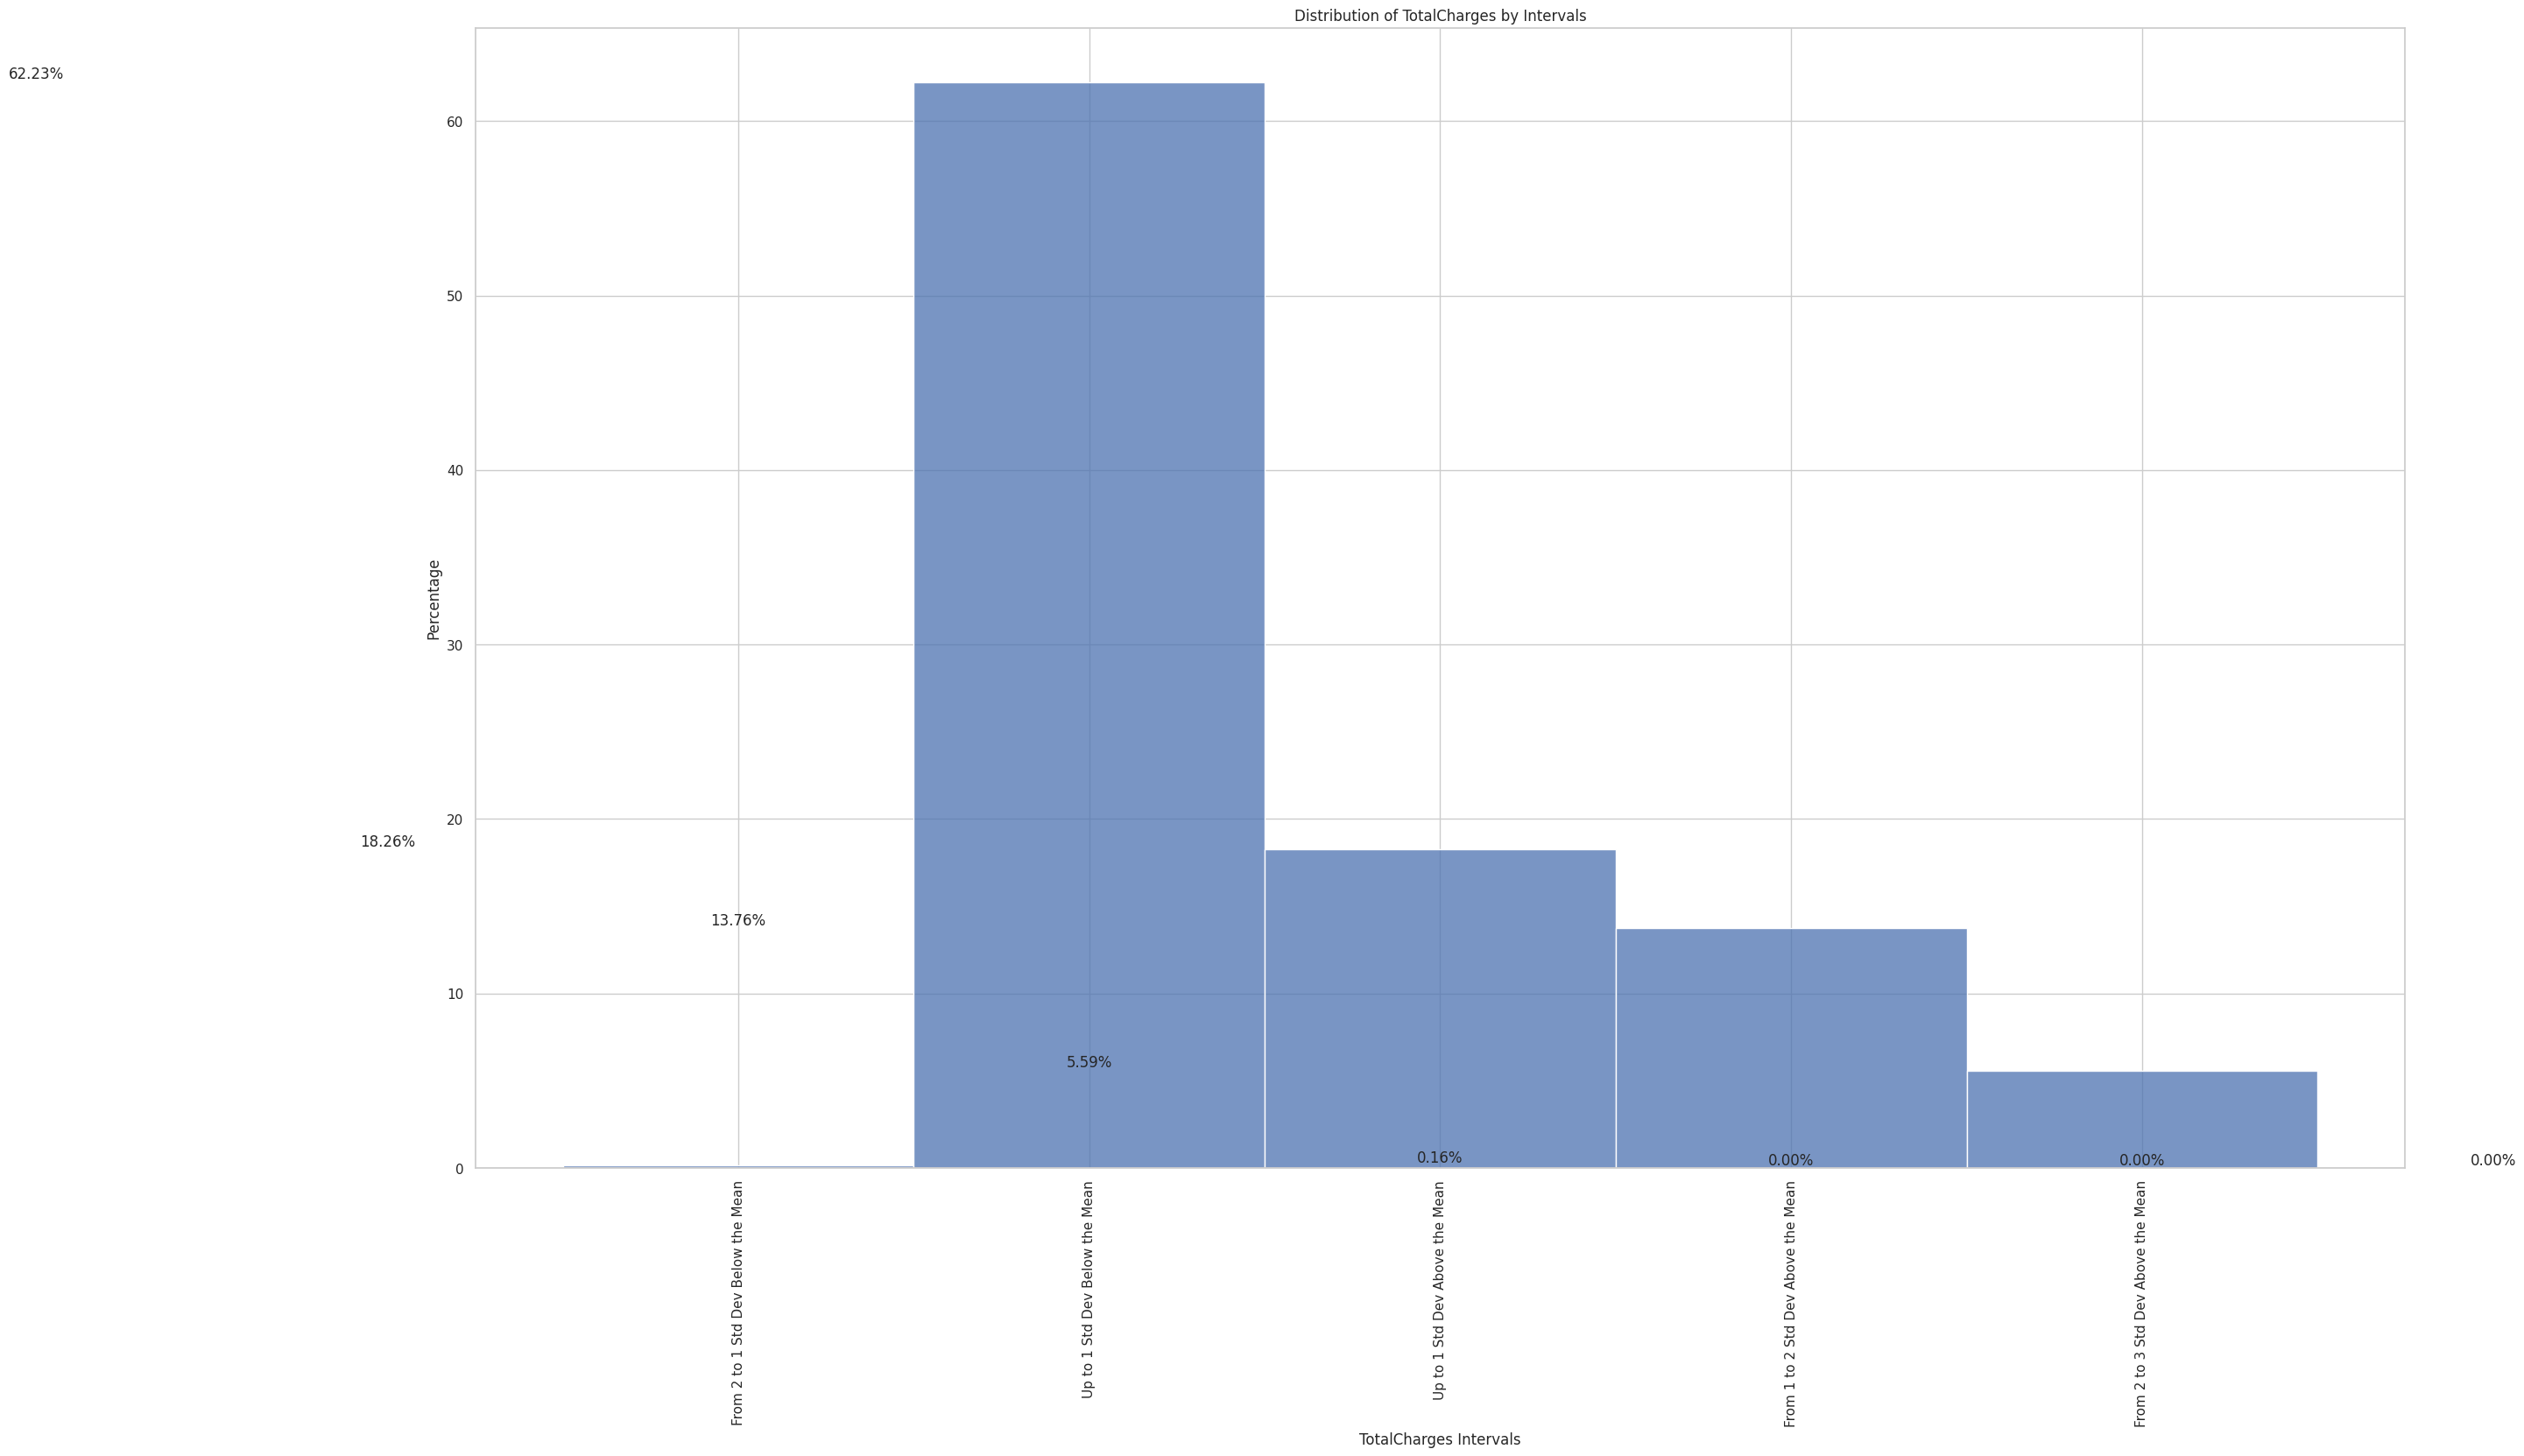

In [26]:
def plot_distribution(data, categorical_columns, numeric_columns):
    num_cols = 2  # Number of subplots per row
    num_rows_categ = math.ceil(len(categorical_columns) / num_cols)  # Number of rows for categorical columns
    num_rows_num = math.ceil(len(numeric_columns) / num_cols)  # Number of rows for numeric columns

    # Plotting the graphs for categorical columns
    for i, column in enumerate(categorical_columns):
        if i % num_cols == 0:  # Start a new row
            plt.figure(figsize=(50, 30))  # Set the figure size
        plt.subplot(num_rows_categ, num_cols, i % num_cols + 1)
        if data[column].dtype == 'object':
            # Calculate the percentages
            percentage = data[column].value_counts(normalize=True) * 100
            sns.barplot(x=percentage.index, y=percentage.values)
            plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Percentage')

            # Adding annotations with percentage values
            for j, val in enumerate(percentage):
                plt.text(j, val, f'{val:.2f}%', ha='center', va='bottom')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Plotting the graphs for numeric columns
    for i, column in enumerate(numeric_columns):
        if i % num_cols == 0:  # Start a new row
            plt.figure(figsize=(50, 30))  # Set the figure size
        plt.subplot(num_rows_num, num_cols, i % num_cols + 1)
        # Calculate mean and standard deviation
        mean = data[column].mean()
        std_dev = data[column].std()

        # Define the intervals
        intervals = [
            float('-inf'), mean - 3 * std_dev, mean - 2 * std_dev, mean - std_dev, mean,
            mean + std_dev, mean + 2 * std_dev, mean + 3 * std_dev, float('inf')
        ]

        # Create labels for the intervals
        labels = [
            '3 or more Std Dev Below the Mean', 'From 3 to 2 Std Dev Below the Mean',
            'From 2 to 1 Std Dev Below the Mean', 'Up to 1 Std Dev Below the Mean',
            'Up to 1 Std Dev Above the Mean', 'From 1 to 2 Std Dev Above the Mean',
            'From 2 to 3 Std Dev Above the Mean', '3 or more Std Dev Above the Mean'
        ]

        # Create a new column with the intervals
        data[f'{column} Intervals'] = pd.cut(data[column], bins=intervals, labels=labels)

        # Plot the histogram of the intervals
        sns.histplot(data=data, x=f'{column} Intervals', discrete=True, stat='percent', kde=False)
        plt.title(f'Distribution of {column} by Intervals')
        plt.xlabel(f'{column} Intervals')
        plt.ylabel('Percentage')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

        # Adding annotations with percentage values
        for j, val in enumerate(data[f'{column} Intervals'].value_counts(normalize=True) * 100):
            plt.text(j, val, f'{val:.2f}%', ha='center', va='bottom')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Remove the intervals column from the DataFrame
    data.drop(columns=[f'{column} Intervals'], inplace=True)

# Use the function plot_distribution with the parameters dataset, categorical_columns, and numeric_columns
plot_distribution(data, columns_categ, columns_num)


### Bivariate Analysis: Investigating Relationships Between Pairs of Variables


In [27]:
# List of All Variables
colunas = []
colunas = columns_categ + columns_num + columns_bool


<Figure size 1000x600 with 0 Axes>

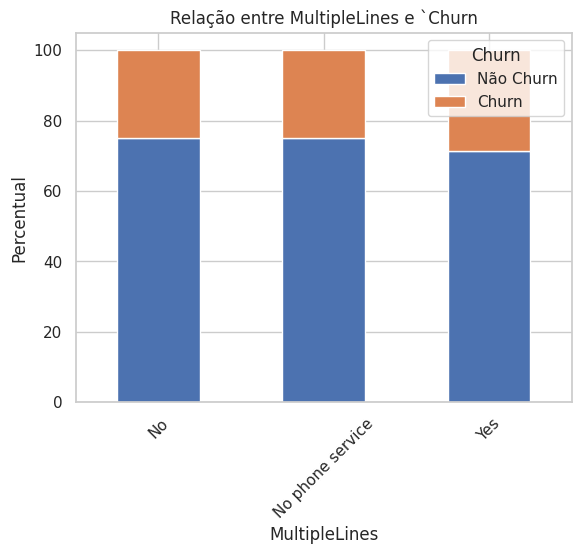

<Figure size 1000x600 with 0 Axes>

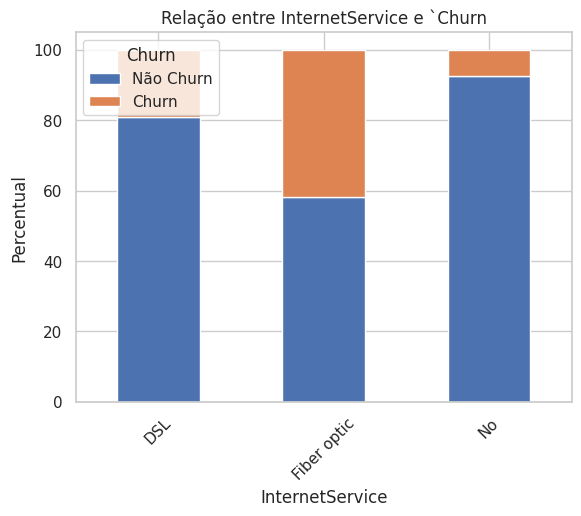

<Figure size 1000x600 with 0 Axes>

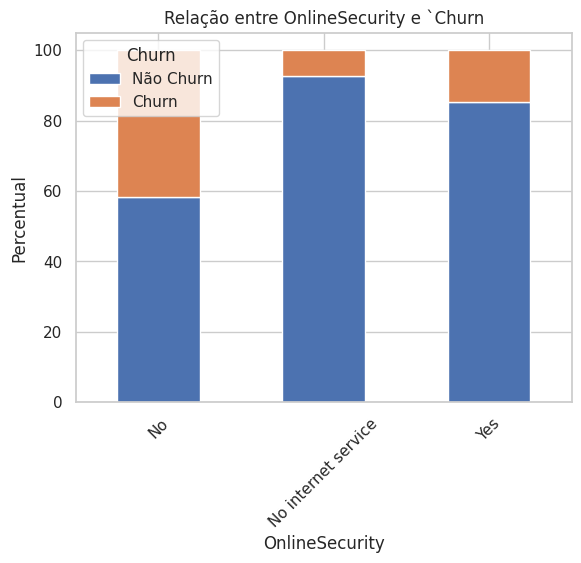

<Figure size 1000x600 with 0 Axes>

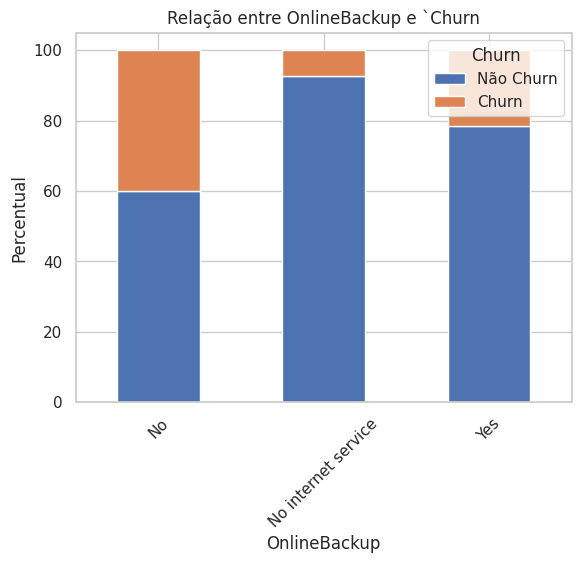

<Figure size 1000x600 with 0 Axes>

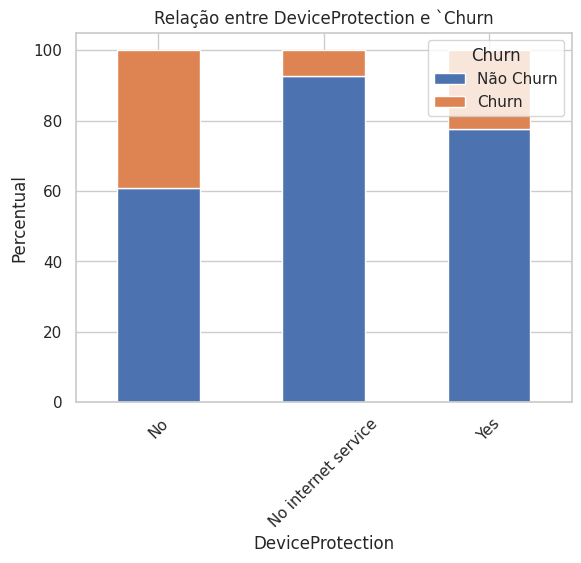

<Figure size 1000x600 with 0 Axes>

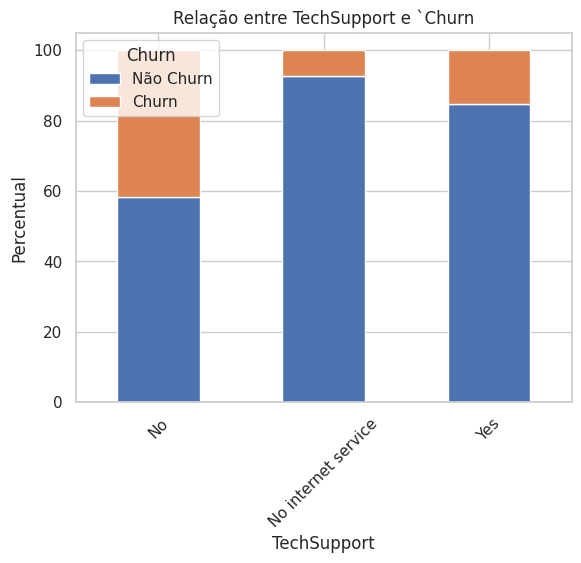

<Figure size 1000x600 with 0 Axes>

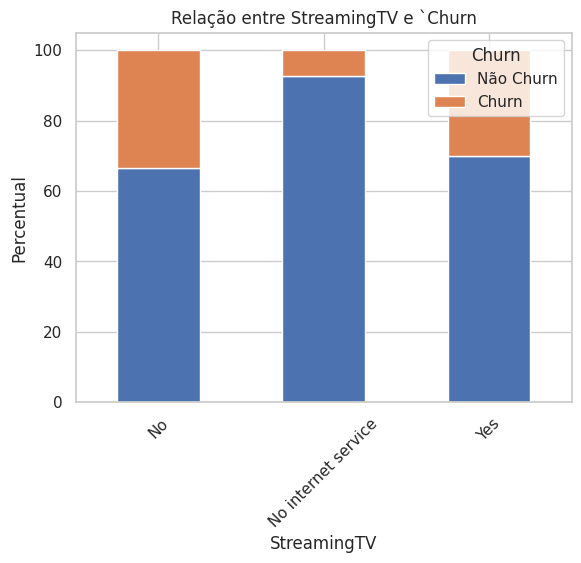

<Figure size 1000x600 with 0 Axes>

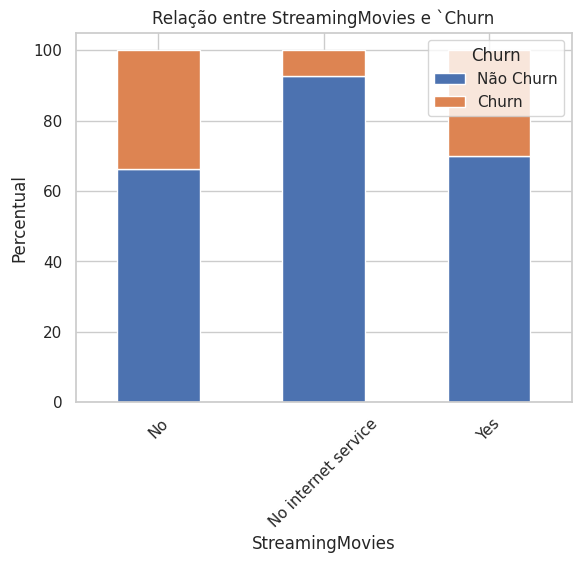

<Figure size 1000x600 with 0 Axes>

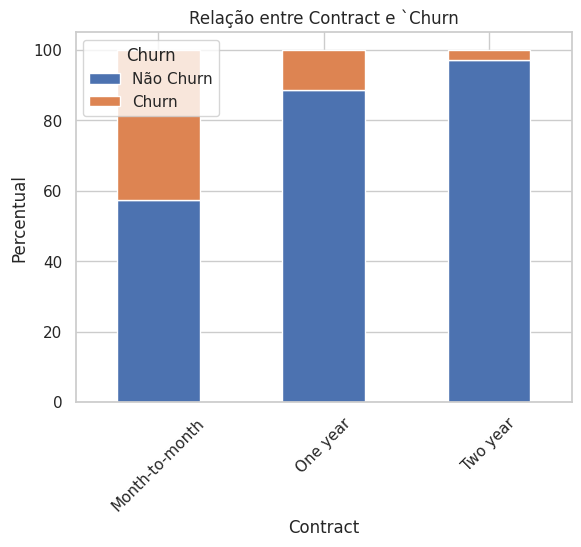

<Figure size 1000x600 with 0 Axes>

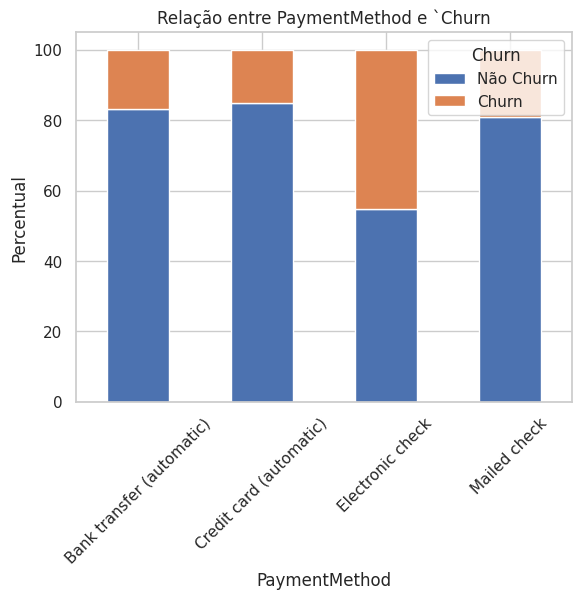

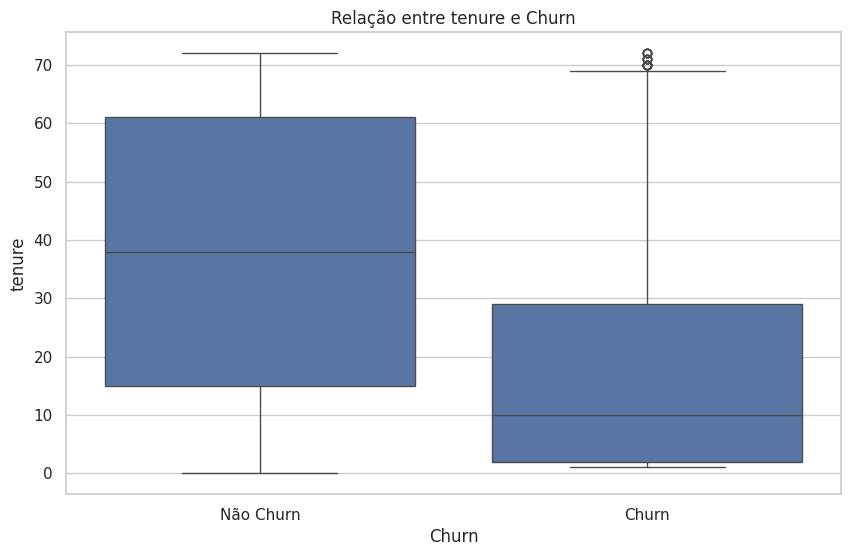

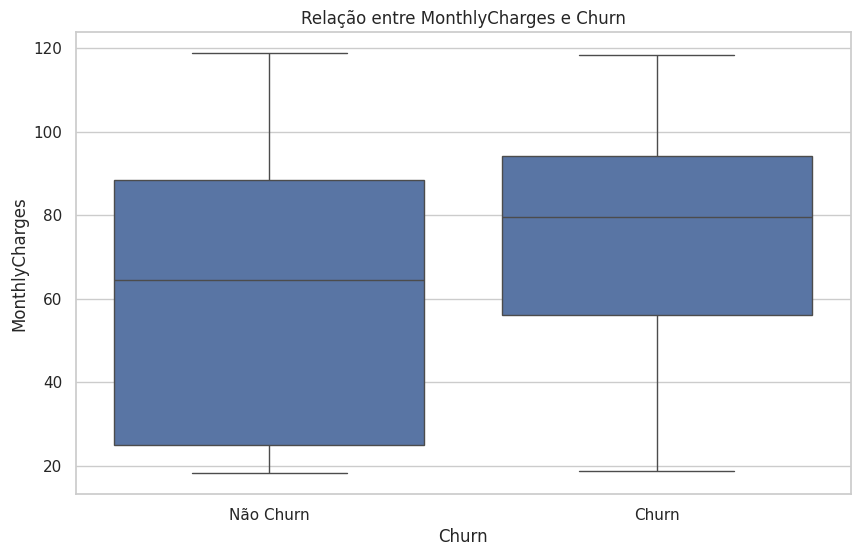

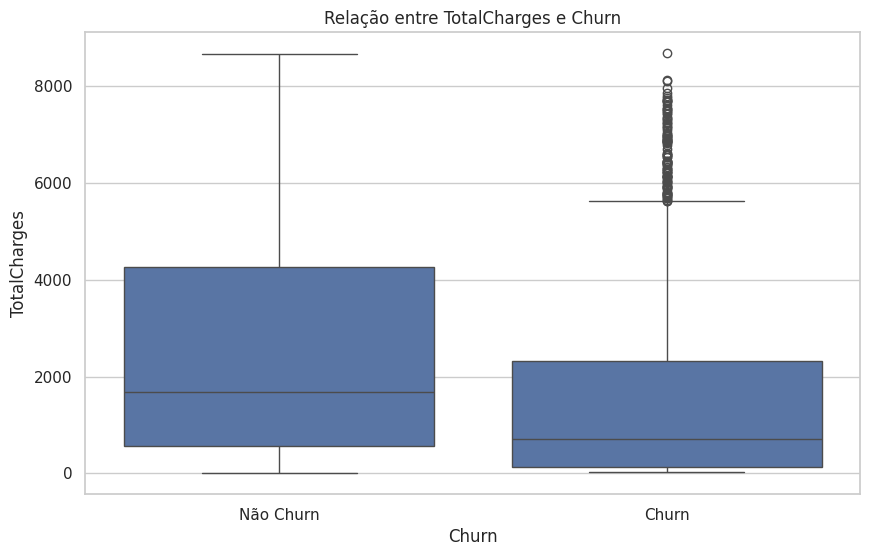

<Figure size 1000x600 with 0 Axes>

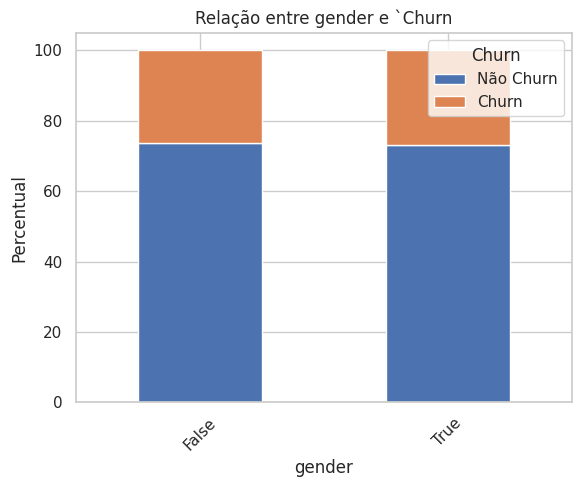

<Figure size 1000x600 with 0 Axes>

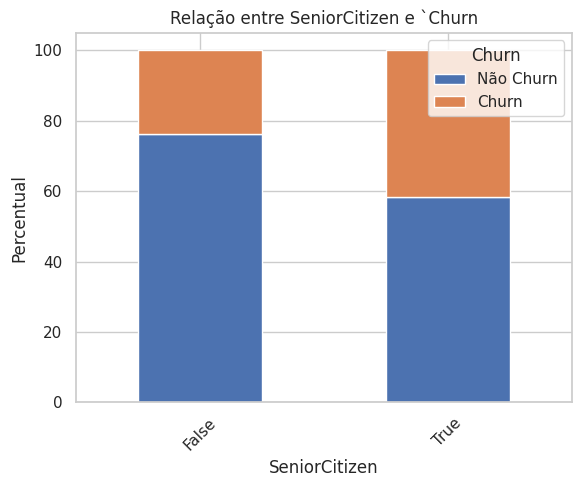

<Figure size 1000x600 with 0 Axes>

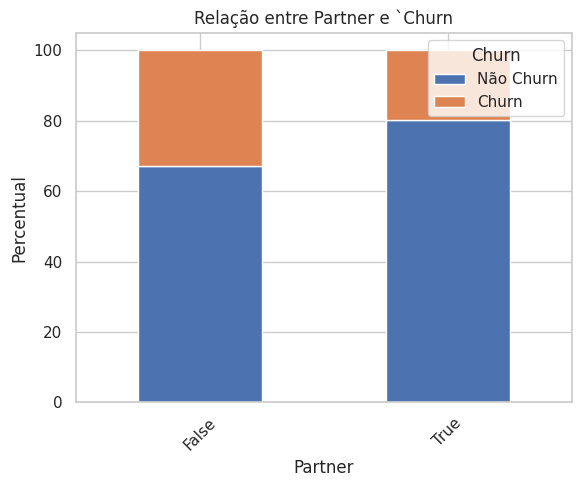

<Figure size 1000x600 with 0 Axes>

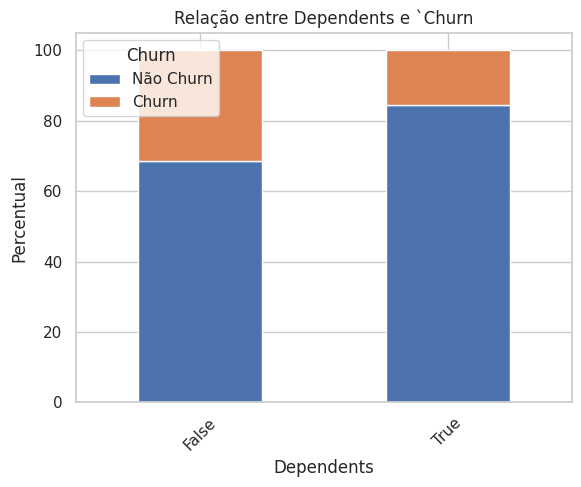

<Figure size 1000x600 with 0 Axes>

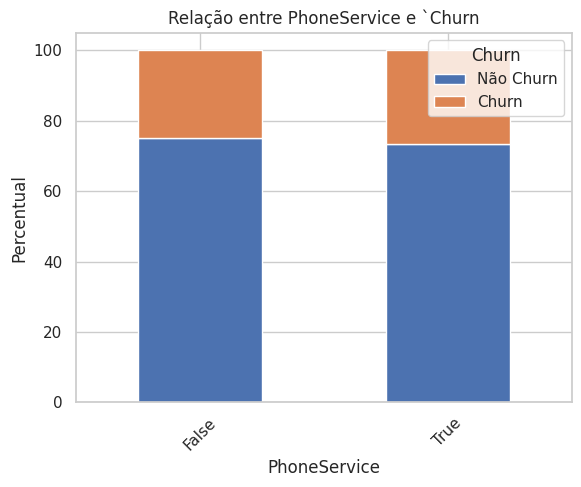

<Figure size 1000x600 with 0 Axes>

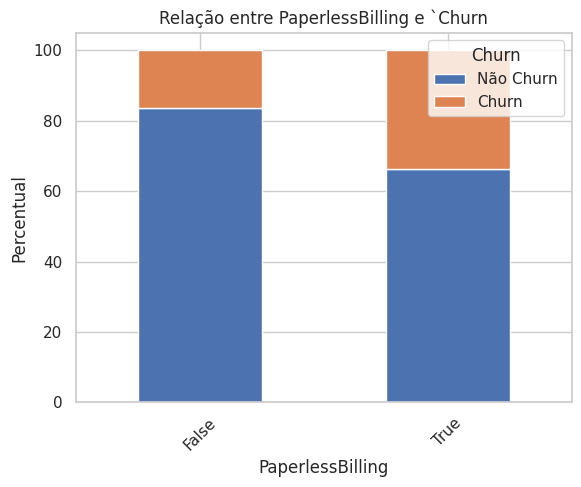

In [28]:
# Column of Interest
target_col = 'Churn'

# Iterate over the columns and create plots for each in relation to churn
def plotar_graficos(dataset, colunas, target_col):
    for coluna in colunas:
        if coluna != target_col:  # Ignore the variable 'Churn' itself
            plt.figure(figsize=(10, 6))  # Set the figure size
            if dataset[coluna].dtype == 'object' or dataset[coluna].dtype == 'bool':
                # If it is a categorical or boolean variable, create a bar chart
                counts = dataset.groupby([coluna, target_col]).size().unstack()
                percentual = counts.div(counts.sum(axis=1), axis=0) * 100
                percentual.plot(kind='bar', stacked=True)
                plt.title(f'Relação entre {coluna} e `{target_col}')
                plt.xlabel(coluna)
                plt.ylabel('Percentual')
                plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                plt.legend(title=f'{target_col}', labels=[f'Não {target_col}', f'{target_col}'])
            else:
                # If it is a numeric variable, create a box plot
                sns.boxplot(data=dataset, x=f'{target_col}', y=coluna)
                plt.title(f'Relação entre {coluna} e {target_col}')
                plt.xlabel(f'{target_col}')
                plt.ylabel(coluna)
                plt.xticks(ticks=[0, 1], labels=[f'Não {target_col}', f'{target_col}'])
            plt.show()

plotar_graficos(data, colunas, target_col)


### Bivariate Analysis Conclusions

These graphs allow us to examine the relationships of some variables in relation to Churn.

- Fiber Optic Product: Where the fiber optic product shows much higher churn rates (approximately 40%) compared to other delivery models.

- Additional Products: Observing the relationship with additional products in relation to churn, customers who do not opt for these services have higher cancellation rates (approximately 40% vs. approximately 20% of customers who have some type of additional service).

- Contract Length: Contract length also influences cancellation, with customers on monthly contracts showing higher rates (above 40%) compared to below 10% in 1 and 2-year contracts.

- Payment Method: The payment method also impacts cancellation, with customers using Electronic Check also having above-average cancellation rates.

- Critical Period of Tenure: From the perspective of the critical tenure period, we have between 10 and 30 months as the period with the highest number of cancellations.

- Average Monthly Payment: Customers who have canceled have a higher average monthly payment than other customers in general, possibly suggesting they are customers with higher demands.

- Age of Customers: Older people tend to cancel more as we saw in the distribution (40% vs. 20%).


## Actionable Insights

- Additional products, contract length, and payment method are variables that can be proactively changed. Offering customers discounts and benefits to switch to annual plan formats, acquire additional services, and use payment methods with lower associated cancellation rates can be effective.

- From the perspective of targeting, the variables of tenure length, average monthly payment, and demographic variables associated with a higher churn rate allow us to focus on a specific audience with a higher propensity for churn.


## Further Focusing Actions
Below, we will work with clustering methods to segment groups with higher cancellation rates, identify the drivers, and establish ways to mitigate them. Segmenting customers into clusters allows the cancellation mitigation efforts to be even more specific for each group and to prioritize groups with greater urgency.


## Preparing the Dataset for the Clustering Model


In [33]:
# Perform hot encoding of categorical variables
data_encoded = pd.get_dummies(data, columns=columns_categ, drop_first=True)

# Normalize the numeric variables
scaler = StandardScaler()
data_encoded[columns_num] = scaler.fit_transform(data_encoded[columns_num])

# Ensure that boolean variables are already encoded as 0 and 1 (if necessary)
for column in columns_bool:
  data_encoded[column] = data_encoded[column].astype(bool)

data_encoded = data_encoded.drop(['tenure Intervals', 'MonthlyCharges Intervals'], axis=1)
data_encoded = data_encoded[data_encoded.columns[1:]]
data_encoded.dtypes

gender                                      bool
SeniorCitizen                               bool
Partner                                     bool
Dependents                                  bool
tenure                                   float64
PhoneService                                bool
PaperlessBilling                            bool
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                       bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No inter

In [34]:
# Function to find the optimal number of clusters using the Elbow method for K-means
def find_optimal_kmeans(data, max_clusters=5, verbose=True):
    scores = []
    iterator = range(2, max_clusters + 1)
    if verbose:
        iterator = tqdm(iterator, desc="Finding optimal K (Elbow)")
    for k in iterator:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        scores.append(kmeans.inertia_)
    return scores

# Function to find the optimal number of clusters using the Silhouette method for K-means
def find_optimal_kmeans_silhouette(data, max_clusters=5, verbose=True):
    scores = []
    iterator = range(2, max_clusters + 1)
    if verbose:
        iterator = tqdm(iterator, desc="Finding optimal K (Silhouette)")
    for k in iterator:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        scores.append(silhouette_avg)
    return scores

# Function to find the best parameters for DBSCAN
def find_optimal_dbscan(data, min_samples_range=(1, 10), eps_range=(0.1, 2.0), verbose=True):
    best_score = -1
    best_params = None
    min_samples_iterator = range(min_samples_range[0], min_samples_range[1] + 1)
    eps_iterator = range(int(eps_range[0] * 10), int(eps_range[1] * 10) + 1, 1)
    if verbose:
        min_samples_iterator = tqdm(min_samples_iterator, desc="Finding optimal min_samples")
        eps_iterator = tqdm(eps_iterator, desc="Finding optimal eps")
    for min_samples in min_samples_iterator:
        for eps in eps_iterator:
            eps /= 10
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            if len(set(labels)) > 1:  # Ensure there are more than one cluster
                silhouette_avg = silhouette_score(data, labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_params = {'eps': eps, 'min_samples': min_samples}
    return best_params


In [35]:
# Apply K-means with the optimal number of clusters found using the Elbow method
elbow_scores = find_optimal_kmeans(data_encoded)
optimal_k_elbow = elbow_scores.index(min(elbow_scores)) + 2  # Adding 2 because the range starts from 2
kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=42)
kmeans_clusters_elbow = kmeans_elbow.fit_predict(data_encoded)

# Apply K-means with the optimal number of clusters found using the Silhouette method
silhouette_scores = find_optimal_kmeans_silhouette(data_encoded)
optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 because the range starts from 2
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42)
kmeans_clusters_silhouette = kmeans_silhouette.fit_predict(data_encoded)

# Apply DBSCAN
db_params = find_optimal_dbscan(data_encoded)

# Print the best parameters found by DBSCAN
print("Best DBSCAN Parameters:", db_params)

dbscan = DBSCAN(eps=db_params['eps'], min_samples=db_params['min_samples'])
dbscan_clusters = dbscan.fit_predict(data_encoded)

# Evaluate the results
kmeans_silhouette_score = silhouette_score(data_encoded, kmeans_clusters_silhouette)
dbscan_silhouette_score = silhouette_score(data_encoded, dbscan_clusters)



Finding optimal K (Elbow):   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Finding optimal K (Elbow):  25%|██▌       | 1/4 [00:00<00:02,  1.03it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Finding optimal K (Elbow):  50%|█████     | 2/4 [00:01<00:01,  1.18it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Finding optimal K (Elbow):  75%|███████▌  | 3/4 [00:02<00:00,  1.05it/s]/usr/local/lib/python

Best DBSCAN Parameters: {'eps': 0.5, 'min_samples': 1}


In [36]:

print(f"Silhouette Score (K-means - Elbow):{kmeans_silhouette_score}, Optimal k:{optimal_k_elbow}")
print(f"Silhouette Score (K-means - Silhouette):{silhouette_score(data_encoded, kmeans_clusters_elbow)},Optimal k: {optimal_k_silhouette}")
print(f"Silhouette Score (DBSCAN):{dbscan_silhouette_score}, Optimal params: {db_params}" )

Silhouette Score (K-means - Elbow):0.28925425374923913, Optimal k:5
Silhouette Score (K-means - Silhouette):0.20219088310985728,Optimal k: 2
Silhouette Score (DBSCAN):0.22827081858807083, Optimal params: {'eps': 0.5, 'min_samples': 1}


- K-means with Elbow Method: The K-means with the optimal number of clusters found using the elbow method exhibited a coherent internal structure and well-separated clusters, with a Silhouette coefficient of approximately 0.2892.

- K-means with Silhouette Method: The K-means with the optimal number of clusters found using the silhouette method had a less cohesive internal structure and less separated clusters, with a Silhouette coefficient of around 0.2021.

- DBSCAN: The DBSCAN, with optimized parameters, presented moderately defined clusters, with a Silhouette coefficient of approximately 0.2283.

In [38]:
data_encoded = pd.get_dummies(data, columns=columns_categ, drop_first=False)
data_encoded = data_encoded.drop(['tenure Intervals', 'MonthlyCharges Intervals'], axis=1)
data_encoded = data_encoded[data_encoded.columns[1:]]



In [39]:
# Adding K-means clusters as categorical variables to the dataset
data_encoded['KMeansClusters'] = kmeans_clusters_elbow

## Reverting transformations for cluster analysis

### 2. Undoing categorical variable encoding

def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

data_clustered = undummify(data_encoded)


In [40]:
data_clustered['KMeansClusters'] = data_clustered['KMeansClusters'].astype(str)
data_clustered['gender'] = data_clustered['gender'].astype(bool)
data_clustered['SeniorCitizen'] = data_clustered['SeniorCitizen'].astype(bool)
data_clustered['Partner'] = data_clustered['Partner'].astype(bool)
data_clustered['Dependents'] = data_clustered['Dependents'].astype(bool)
data_clustered['PhoneService'] = data_clustered['PhoneService'].astype(bool)
data_clustered['PaperlessBillingn'] = data_clustered['PaperlessBilling'].astype(bool)
data_clustered['Churn'] = data_clustered['Churn'].astype(bool)

## Cluster Analysis


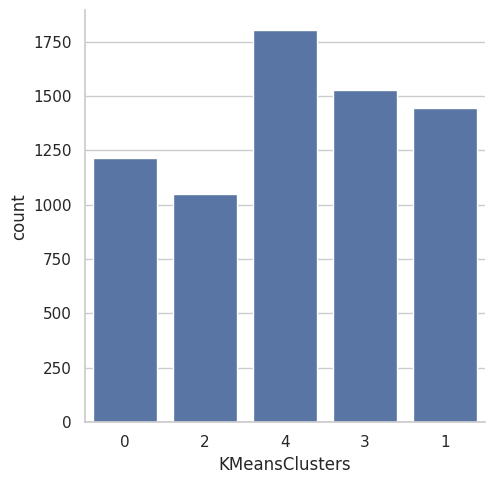

In [41]:
sns.catplot(x='KMeansClusters', kind='count', data=data_clustered)

<Figure size 1000x600 with 0 Axes>

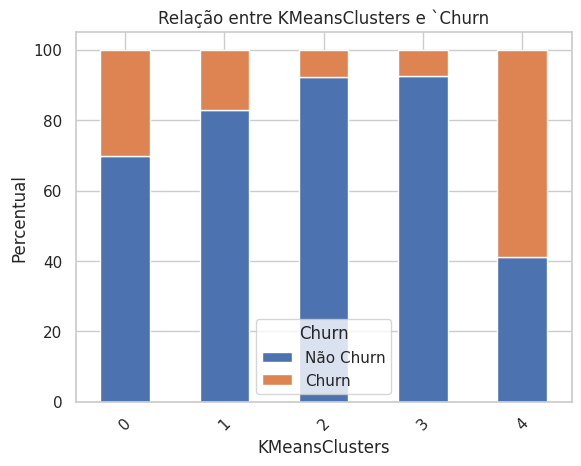

In [43]:
# Column of Interest
target_col = 'Churn'
columns = ['KMeansClusters']

# Iterate over the columns and create plots for each one in relation to churn
plotar_graficos(data_clustered, columns, target_col)


In [44]:
def get_cluster_indicators(df):
    # List of indicators for each cluster, including a general category
    indicators_list = []

    # Extract unique clusters and add the "General" category
    clusters = df['KMeansClusters'].unique().tolist()
    clusters.append('General')

    # Define the columns of interest for analysis
    feature_columns = [
        'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
        'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'Contract', 'PaymentMethod'
    ]

    # Create dummy variables for the columns of interest
    df_dummies = pd.get_dummies(df[feature_columns], drop_first=False)
    feature_columns = df_dummies.columns

    # Add the cluster column and the PaperlessBilling column with bool type
    df_dummies['KMeansClusters'] = df['KMeansClusters']
    df_dummies['PaperlessBilling'] = df_dummies['PaperlessBilling'].astype(bool)
    df = df_dummies

    # Process each cluster and the general category
    for cluster in clusters:
        row = [cluster]
        final_feature_columns = ['cluster']

        if cluster != 'General':
            data_per_cluster = df[df['KMeansClusters'] == cluster]
        else:
            data_per_cluster = df

        for column in feature_columns:
            if data_per_cluster[column].dtype == 'bool':
                # Calculate the percentage of True values
                percentage_true = data_per_cluster[column].sum() / len(data_per_cluster[column])
                row.append(percentage_true)
                if f'% of {column}' not in final_feature_columns:
                    final_feature_columns.append(f'% of {column}')
            elif data_per_cluster[column].dtype in ['float64', 'int']:
                # Calculate the mean for numeric columns
                mean_value = data_per_cluster[column].mean()
                if f'Mean of {column}' not in final_feature_columns:
                    final_feature_columns.append(f'Mean of {column}')
                row.append(mean_value)

        indicators_list.append(row)

    # Convert the list to a DataFrame and adjust the first row as header
    indicators_df = pd.DataFrame(indicators_list, columns=final_feature_columns).T
    indicators_df.columns = indicators_df.iloc[0]
    indicators_df = indicators_df.drop(indicators_df.index[0])

    return indicators_df

get_cluster_indicators(data_clustered)


cluster,0,2,4,3,1,General
% of Churn,0.301809,0.076263,0.588366,0.07405,0.170698,0.26537
% of gender,0.471217,0.491897,0.508587,0.489515,0.507256,0.495244
% of SeniorCitizen,0.109375,0.112488,0.2759,0.034076,0.23566,0.162147
% of Partner,0.302632,0.63775,0.337396,0.483617,0.703525,0.483033
% of Dependents,0.257401,0.406101,0.147368,0.421363,0.319281,0.299588
Mean of tenure,12.168586,50.792183,14.276454,30.547182,60.489288,32.371149
% of PhoneService,0.67023,0.732126,1.0,1.0,1.0,0.903166
% of PaperlessBilling,0.541941,0.528122,0.792798,0.292267,0.747063,0.592219
Mean of MonthlyCharges,48.558923,65.50448,84.690416,21.079194,99.047478,64.761692
Mean of TotalCharges,589.046258,3273.45572,1238.884349,662.604784,5983.906185,2279.734304


### Churn Analysis by Cluster

- % Churn: Cluster 4 has a churn percentage of 58.84%, which is much higher than the other clusters and the overall (26.54%). This high value highlights the importance of investigating and addressing the underlying causes of churn in this cluster.

Relevant Variables for Churn in Cluster 4

- % SeniorCitizen (27.59%): Significantly higher than the overall average (16.21%), suggesting a higher proportion of seniors who may have specific expectations or issues with service usage that need to be addressed.

- Mean MonthlyCharges (84.70): This value is much higher than the overall average of 64.7, indicating that customers in this cluster are paying significantly more each month, which may contribute to dissatisfaction and subsequent churn.

- % InternetService_Fiber optic (96.45%): Almost all customers in this cluster use fiber optic, which, while being a high-speed service, may be more susceptible to unmet expectations related to quality and reliability.

- % PaymentMethod_Electronic check (64.76%): This payment method is predominantly used in cluster 4, which may indicate convenience or trust issues with this method.

- % Contract_Month-to-month (94.96%): The overwhelming majority are on month-to-month contracts, which offer less long-term security for the company and greater freedom for customers to switch services, thereby facilitating churn.

- % OnlineSecurity_No (86.37%) and % TechSupport_No (85.04%): High rates of customers without additional online security and technical support services, which are important for customer satisfaction and trust, especially in a cluster with high fiber optic usage.

- Tenure: Customers in cluster 4 are mostly within the critical period spotted in the bivariate analysis of 10 to 30 months.

## Conclusions and Recommendations

Cluster 4 shows a combination of high-risk factors that may be contributing to the high churn: high monthly costs, predominant use of fiber optic, prevalence of monthly contracts, potentially problematic payment methods, and lack of additional services such as online security and technical support.
Recommendations:

- Pricing and Promotions Review: Consider restructuring pricing plans or introducing discounts or promotions for long-term customers to increase perceived value.
- Service and Support Improvements: Investing in the quality of fiber optic service and offering better options for technical support and online security can help reduce the churn rate.
- Incentives for Long-Term Contracts: Encouraging customers to switch from monthly contracts to annual or biennial contracts through incentives can increase retention.
- Payment Methods Reassessment: Analyzing and potentially improving the process for electronic check payments, ensuring it is secure and convenient.

Focusing on these areas can significantly improve customer satisfaction in cluster 4 and reduce its high churn rate.


## Final Comments

Clustering was effective in identifying customer profiles and their churn probabilities, providing detailed insights for personalized retention strategies. This method highlighted high-risk groups, such as the cluster with a high churn rate, allowing for focused interventions and resource optimization. Additionally, it provided a basis for targeted actions, enhancing the effectiveness of retention initiatives and increasing long-term profitability.
